In [23]:
import mne
from mne.datasets import sample
from mne.preprocessing import ICA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [25]:
from mne.datasets import sample
data_path = sample.data_path(path="./")
data_raw_file = (data_path / "MEG" / "sample" / "sample_audvis_raw.fif")
raw = mne.io.read_raw_fif(data_raw_file, preload=True)

Opening raw data file MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


In [26]:
raw.pick_types(eeg=True)  # EEG 데이터만 선택
print(raw.info)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
<Info | 19 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 59 EEG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 59
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: []
 sfreq: 600.6 Hz
>


In [10]:
print("channels: ", raw.ch_names)
raw.plot(title="Raw EEG Data", duration=5, n_channels=10)

channels:  ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 017', 'EEG 018', 'EEG 019', 'EEG 020', 'EEG 021', 'EEG 022', 'EEG 023', 'EEG 024', 'EEG 025', 'EEG 026', 'EEG 027', 'EEG 028', 'EEG 029', 'EEG 030', 'EEG 031', 'EEG 032', 'EEG 033', 'EEG 034', 'EEG 035', 'EEG 036', 'EEG 037', 'EEG 038', 'EEG 039', 'EEG 040', 'EEG 041', 'EEG 042', 'EEG 043', 'EEG 044', 'EEG 045', 'EEG 046', 'EEG 047', 'EEG 048', 'EEG 049', 'EEG 050', 'EEG 051', 'EEG 052', 'EEG 054', 'EEG 055', 'EEG 056', 'EEG 057', 'EEG 058', 'EEG 059', 'EEG 060']
Using qt as 2D backend.


In [27]:
# 데이터 전처리
raw.filter(1, 40, fir_design='firwin', skip_by_annotation='edge')  # 1-40 Hz bandpass filter
raw.notch_filter([50, 100], picks='eeg')  # 50 Hz and 100 Hz notch filter for power line noise

# EEG 평균 참조 (re-reference)
raw.set_eeg_reference('average', projection=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1983 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3965 samples (6.602 s)

EEG channel type selected for re-referencing


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<Raw | sample_audvis_raw.fif, 59 x 166800 (277.7 s), ~78.0 MB, data loaded>

In [28]:
# 고차원 ICA를 통한 아티팩트 제거
ica = ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # 예시로 아티팩트를 제거할 컴포넌트 번호를 지정
raw_clean = raw.copy().drop_channels([ch for ch in raw.info['ch_names'] if ch in ica.exclude])

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.6s.


In [ ]:
# PSD 계산 (알파 및 세타 밴드에 대해, EEG 데이터만 선택)
fmin, fmax = 4, 12  # 알파와 세타 밴드 범위
psd, freqs = mne.time_frequency.psd_array_welch(raw_clean.get_data(), sfreq=raw_clean.info['sfreq'], fmin=fmin, fmax=fmax, n_fft=2048)

Effective window size : 3.410 (s)


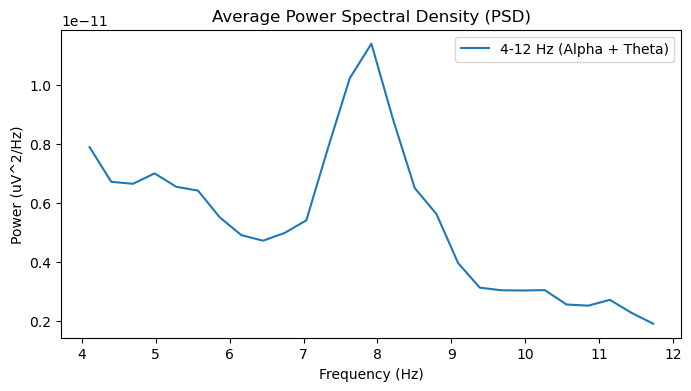

In [32]:
# PSD 값 시각화
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd.mean(axis=0), label=f'{fmin}-{fmax} Hz (Alpha + Theta)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (uV^2/Hz)')
plt.title('Average Power Spectral Density (PSD)')
plt.legend()
plt.show()